<a href="https://colab.research.google.com/github/Cola0912/3dp-webcam-detection/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python-headless
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


画像の読み込みに成功しました。


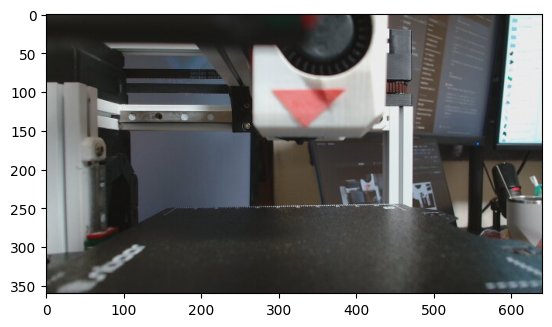

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import

image_path = '/content/drive/MyDrive/3dp-webcam-detection/testpicturs/3.jpg'
image = cv2.imread(image_path)
if image is None:
    print("画像の読み込みに失敗しました。ファイルパスを確認してください。")
else:
    print("画像の読み込みに成功しました。")

# OpenCVとpltで色空間の扱いが異なる。
# OpenCV : BGR
# matplotlib : RGB
# BGRからRGBに変換
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# RGB画像を表示
plt.imshow(image_rgb)
plt.show()

In [36]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


色範囲の指定

In [37]:
_, binary_image = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)
#adaptive_thresh = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# 青色の範囲を定義
lower_blue = np.array([110, 50, 50])
upper_blue = np.array([130, 255, 255])


# 色相の低い側の赤色範囲
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([10, 255, 255])

# 色相の高い側の赤色範囲
lower_red2 = np.array([160, 100, 100])
upper_red2 = np.array([180, 255, 255])



In [38]:
# 青色のみマスク
#blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

# 二値化画像の生成
#blue_binary_image = cv2.bitwise_and(image, image, mask=blue_mask)

# 赤色部分のみマスク
red_mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
red_mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
red_mask = cv2.bitwise_or(red_mask1, red_mask2)

# 二値化画像の生成
red_binary_image = cv2.bitwise_and(image, image, mask=red_mask)

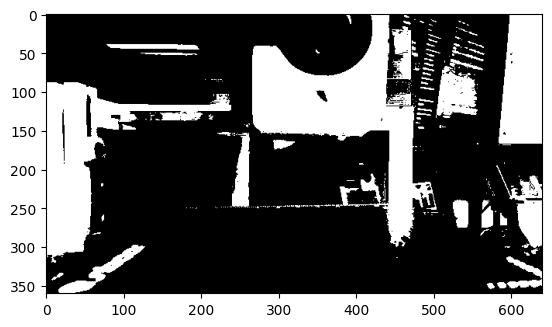

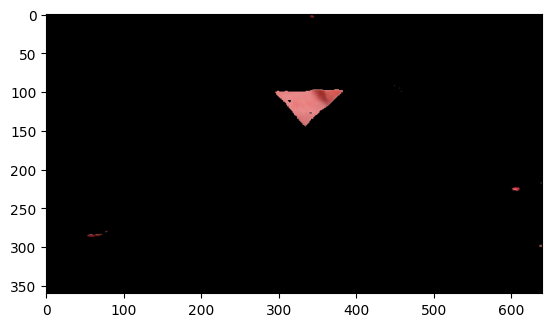

In [39]:
plt.imshow(binary_image, cmap='gray')
plt.show()

#plt.imshow(cv2.cvtColor(blue_binary_image, cv2.COLOR_BGR2RGB))
#plt.show()

plt.imshow(cv2.cvtColor(red_binary_image, cv2.COLOR_BGR2RGB))
plt.show()
